Below cell installs all the necessary modules and packages 

In [ ]:
!add-apt-repository ppa:ubuntugis/ubuntugis-unstable -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree

!pip install rasterio
!pip install geopandas
!pip install descartes
!pip install rio-tiler
!pip install supermercado
!pip install mercantile
!pip install rio-cogeo



THe folders are created in order to store the dataset

In [1]:
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from pathlib import Path
import rasterio
import os

data_dir = Path("data")

img_path = data_dir/'images-256'
mask_path = data_dir/'masks-256'
img_path.mkdir(exist_ok=True)
mask_path.mkdir(exist_ok=True)

tif_url is th path to orthomosiac file.
geojson_file is path to buildings json file of the corresponding orthomosiac file

In [2]:
tif_url = 'plainfield_ward1_mosaic_group1.tif'
geojson_url = 'pf_buildings.geojson'


In [3]:
rasterio.open(tif_url).meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 95544,
 'height': 114938,
 'count': 4,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(0.02619, 0.0, 548436.10433,
        0.0, -0.02619, 4498882.28246)}

In [4]:
label_df = gpd.read_file(geojson_url)
label_df = label_df[label_df['geometry'].isna() != True]

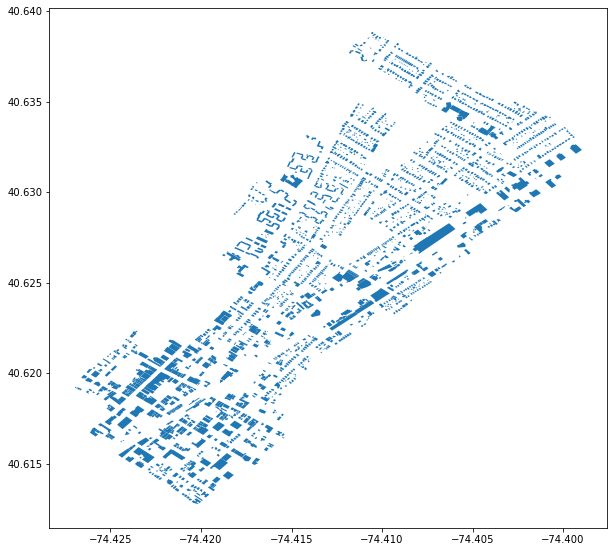

In [5]:
label_df.plot(figsize=(10,10))


In [6]:
tile_size = 256
zoom_level = 19

THe geojson file given below is for dividing the orthomosiac into training and validation area.
This geojson can be created at the following link:
    http://geojson.io/
Upload the buildings geojson to the above link. Delete all the polyons on right pane and draw the polygons as given in the below json file
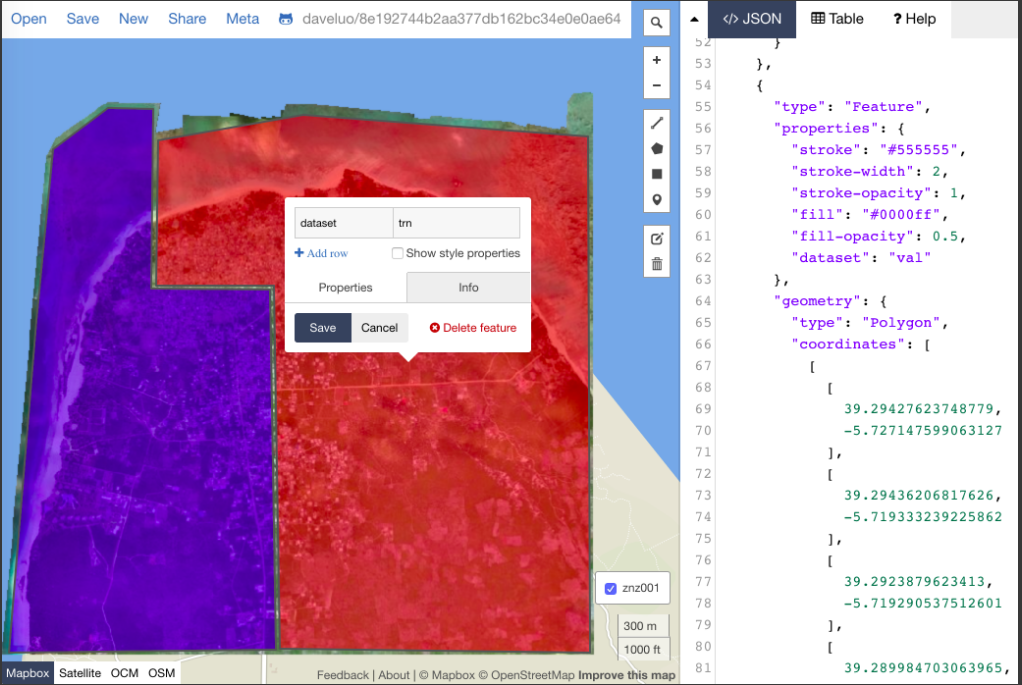

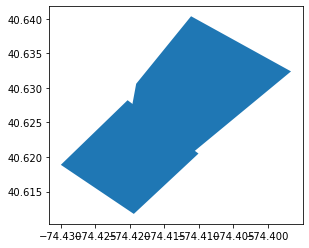

In [7]:
aoi_df = gpd.read_file('pf.geojson')
aoi_df.plot()

In [8]:
aoi_df[aoi_df['dataset']=='trn']['geometry'].to_file('trn_aoi.geojson', driver='GeoJSON')
aoi_df[aoi_df['dataset']=='val']['geometry'].to_file('val_aoi.geojson', driver='GeoJSON')

In [9]:
!cat trn_aoi.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > trn_aoi_z{zoom_level}tiles.geojson
!cat val_aoi.geojson | supermercado burn {zoom_level} | mercantile shapes | fio collect > val_aoi_z{zoom_level}tiles.geojson

In [10]:
trn_tiles = gpd.read_file(f'trn_aoi_z{zoom_level}tiles.geojson')
val_tiles = gpd.read_file(f'val_aoi_z{zoom_level}tiles.geojson')
trn_tiles['dataset'] = 'trn'
val_tiles['dataset'] = 'val'

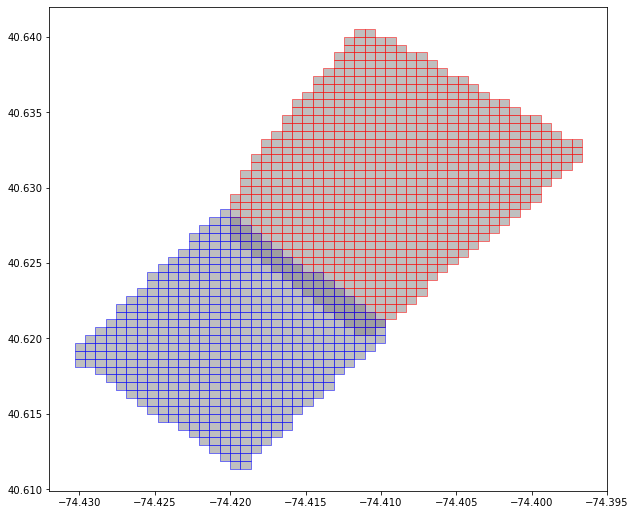

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
trn_tiles.plot(ax=ax, color='grey', alpha=0.5, edgecolor='red')
val_tiles.plot(ax=ax, color='grey', alpha=0.5, edgecolor='blue')

In [12]:
import pandas as pd
tiles_gdf = gpd.GeoDataFrame(pd.concat([trn_tiles, val_tiles], ignore_index=True), crs=trn_tiles.crs)
tiles_gdf.drop_duplicates(subset=['id'], inplace=True)

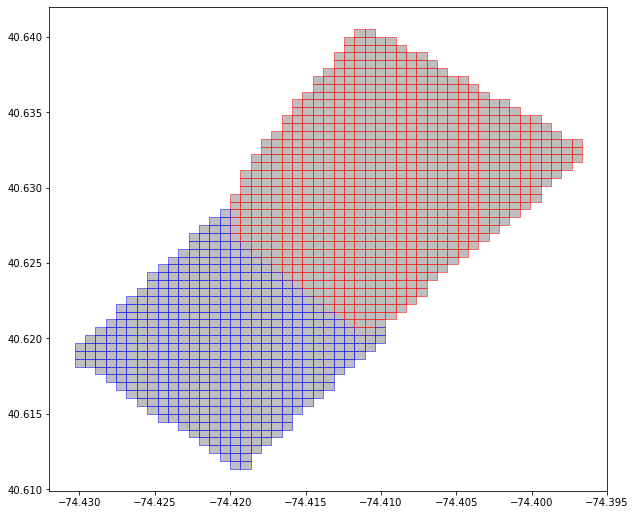

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
tiles_gdf[tiles_gdf['dataset'] == 'trn'].plot(ax=ax, color='grey', edgecolor='red', alpha=0.5)
tiles_gdf[tiles_gdf['dataset'] == 'val'].plot(ax=ax, color='grey', edgecolor='blue', alpha=0.5)

In [14]:
tiles_gdf.head()

,id,title,geometry,dataset
0,"(153774, 197261, 19)","XYZ tile (153774, 197261, 19)","POLYGON ((-74.41177 40.64001, -74.41177 40.640...",trn
1,"(153775, 197261, 19)","XYZ tile (153775, 197261, 19)","POLYGON ((-74.41109 40.64001, -74.41109 40.640...",trn
2,"(153773, 197262, 19)","XYZ tile (153773, 197262, 19)","POLYGON ((-74.41246 40.63949, -74.41246 40.640...",trn
3,"(153774, 197262, 19)","XYZ tile (153774, 197262, 19)","POLYGON ((-74.41177 40.63949, -74.41177 40.640...",trn
4,"(153775, 197262, 19)","XYZ tile (153775, 197262, 19)","POLYGON ((-74.41109 40.63949, -74.41109 40.640...",trn


In [15]:
def reformat_xyz(tile_gdf):
  tile_gdf['xyz'] = tile_gdf.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
  tile_gdf['xyz'] = [[int(q) for q in p] for p in tile_gdf['xyz']]
  return tile_gdf

In [16]:
tiles_gdf = reformat_xyz(tiles_gdf)
tiles_gdf.head()

,id,title,geometry,dataset,xyz
0,"(153774, 197261, 19)","XYZ tile (153774, 197261, 19)","POLYGON ((-74.41177 40.64001, -74.41177 40.640...",trn,"[153774, 197261, 19]"
1,"(153775, 197261, 19)","XYZ tile (153775, 197261, 19)","POLYGON ((-74.41109 40.64001, -74.41109 40.640...",trn,"[153775, 197261, 19]"
2,"(153773, 197262, 19)","XYZ tile (153773, 197262, 19)","POLYGON ((-74.41246 40.63949, -74.41246 40.640...",trn,"[153773, 197262, 19]"
3,"(153774, 197262, 19)","XYZ tile (153774, 197262, 19)","POLYGON ((-74.41177 40.63949, -74.41177 40.640...",trn,"[153774, 197262, 19]"
4,"(153775, 197262, 19)","XYZ tile (153775, 197262, 19)","POLYGON ((-74.41109 40.63949, -74.41109 40.640...",trn,"[153775, 197262, 19]"


In [17]:
from rio_tiler import main as rt_main
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

In [18]:
idx = 121
tiles_gdf.iloc[idx]['xyz']

[153775, 197271, 19]

In [19]:
tile, mask = rt_main.tile(tif_url, *tiles_gdf.iloc[idx]['xyz'], tilesize=tile_size)

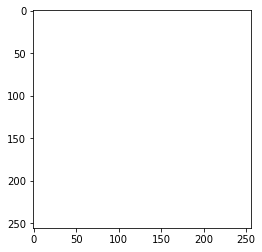

In [20]:
plt.imshow(np.moveaxis(tile,0,2))

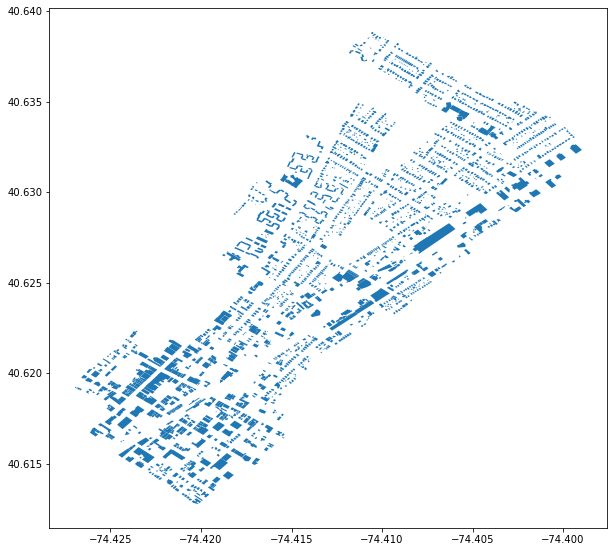

In [21]:
label_df.plot(figsize=(10,10))

In [22]:
all_polys = label_df.geometry

In [23]:
def explode(gdf):
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out
def cleanup_invalid_geoms(all_polys):
  all_polys_merged = gpd.GeoDataFrame()
  all_polys_merged['geometry'] = gpd.GeoSeries(cascaded_union([p.buffer(0) for p in all_polys]))

  gdf_out = explode(all_polys_merged)
  gdf_out = gdf_out.reset_index()
  gdf_out.drop(columns=['level_0','level_1'], inplace=True)
  all_polys = gdf_out['geometry']
  return all_polys

all_polys = cleanup_invalid_geoms(all_polys)

(-74.41108703613281, 40.634798844041626, -74.410400390625, 40.63531992074745)


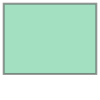

In [24]:
tile_poly = tiles_gdf.iloc[idx]['geometry']
print(tile_poly.bounds)
tile_poly

In [25]:
tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
tfm

Affine(2.682209014892578e-06, 0.0, -74.41108703613281,
       0.0, -2.0354558821211732e-06, 40.63531992074745)

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


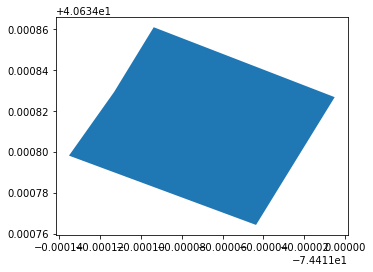

In [26]:
cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs={'init': 'epsg:4326'})
cropped_polys_gdf.plot()

In [27]:
import solaris as sol

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sagar/miniconda3/envs/solaris/lib/pyt

In [28]:
fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)

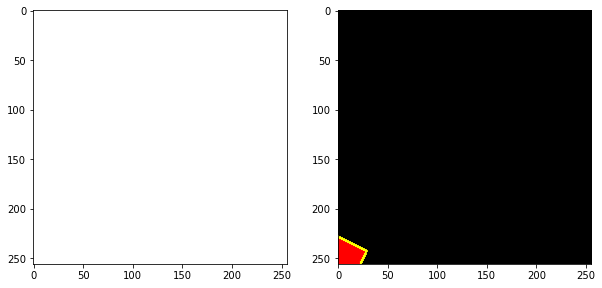

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.imshow(np.moveaxis(tile,0,2))
ax2.imshow(fbc_mask)

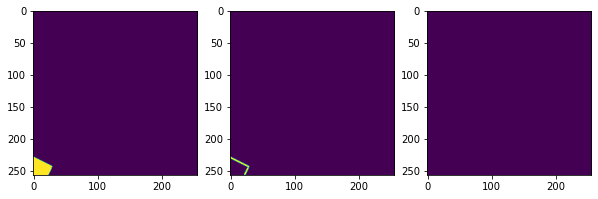

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10, 5))
ax1.imshow(fbc_mask[:,:,0])
ax2.imshow(fbc_mask[:,:,1])
ax3.imshow(fbc_mask[:,:,2])

In [31]:
import skimage
from tqdm import tqdm

In [40]:
def save_tile_img(tif_url, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  try:
      tile, mask = rt_main.tile(tif_url, x,y,z, tilesize=tile_size)
      if display: 
        plt.imshow(np.moveaxis(tile,0,2))
        plt.show()

      skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}.png',np.moveaxis(tile,0,2), check_contrast=False)
  except:
    pass

In [49]:
def save_tile_mask(labels_poly, tile_poly, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
  
  cropped_polys = [poly for poly in labels_poly if poly.intersects(tile_poly)]
  cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs={'init': 'epsg:4326'})
  
  fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,channels=['footprint', 'boundary', 'contact'],affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)
  
  if display: plt.imshow(fbc_mask); plt.show()
  
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.png',fbc_mask, check_contrast=False) 

In [42]:
tiles_gdf[tiles_gdf['dataset'] == 'trn'].shape, tiles_gdf[tiles_gdf['dataset'] == 'val'].shape

((745, 5), (474, 5))

In [43]:
for idx, tile in tqdm(tiles_gdf.iterrows()):
  dataset = tile['dataset']
  save_tile_img('plainfield_ward1_mosaic_group1.tif', tile['xyz'], tile_size, save_path=img_path, prefix=f'znz001{dataset}_', display=False)

1219it [1:49:59,  5.41s/it]


In [50]:
for idx, tile in tqdm(tiles_gdf.iterrows()):
  dataset = tile['dataset']
  tile_poly = tile['geometry']
  save_tile_mask(all_polys, tile_poly, tile['xyz'], tile_size, save_path=mask_path,prefix=f'znz001{dataset}_', display=False)

17it [00:00, 40.89it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
25it [00:00, 30.26it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<auth

110it [00:06, 11.00it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
121it [00:07, 16.90it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

155it [00:09,  9.95it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
157it [00:09,  8.91it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

196it [00:12, 10.97it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
198it [00:13,  8.89it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
226it [00:15, 10.06it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the 

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
257it [00:18,  8.33it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the 

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
287it [00:21,  8.59it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the 

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
316it [00:24, 10.04it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the 

335it [00:27,  7.11it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
336it [00:27,  7.46it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
345it [00:27, 12.01it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' sy

363it [00:30,  7.40it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
364it [00:30,  7.60it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
365it [00:30,  8.06it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' sy

387it [00:32,  7.31it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
388it [00:32,  7.43it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
389it [00:32,  7.44it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' sy

411it [00:35,  9.18it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
413it [00:35,  9.09it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

438it [00:37,  9.63it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
440it [00:37,  8.79it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

462it [00:40, 12.00it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
465it [00:40, 11.16it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

483it [00:42,  7.19it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
484it [00:42,  7.37it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
485it [00:43,  7.47it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' sy

510it [00:45,  7.83it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
511it [00:45,  8.33it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
512it [00:45,  8.39it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' sy

539it [00:48,  9.89it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
541it [00:48,  9.73it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

571it [00:50, 10.25it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
573it [00:51,  9.37it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
598it [00:53, 10.29it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the 

621it [00:56, 10.86it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
623it [00:56,  8.83it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

644it [00:59,  8.88it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
646it [00:59,  7.79it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

667it [01:01,  9.14it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
668it [01:01,  9.16it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
669it [01:01,  9.22it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' sy

693it [01:04,  9.45it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
695it [01:04, 10.27it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

726it [01:07, 11.93it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
728it [01:07,  9.91it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
835it [01:12, 15.66it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
840it [01:12, 19.51it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

866it [01:15,  7.71it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
867it [01:15,  8.11it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
868it [01:15,  8.40it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' sy

896it [01:17,  8.64it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
898it [01:18,  8.63it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
921it [01:20,  8.12it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the 

950it [01:23,  8.45it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
952it [01:23,  7.89it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<au

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
981it [01:26,  8.06it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the 

1013it [01:29,  9.70it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1015it [01:29,  9.49it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<

1046it [01:32,  7.31it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1055it [01:32, 12.36it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1058it [01:33, 11.46it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>'

1083it [01:35,  9.75it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1085it [01:36,  9.09it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<

1108it [01:38,  7.15it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1109it [01:38,  7.04it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1110it [01:39,  7.35it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>'

1132it [01:41,  8.43it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1133it [01:41,  8.44it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1134it [01:41,  8.71it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>'

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1160it [01:44,  8.71it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1161it [01:44,  7.71it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<

/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1185it [01:47,  8.33it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
1186it [01:47,  7.69it/s]/home/sagar/miniconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<

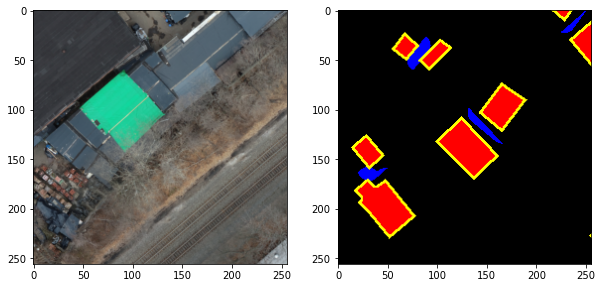

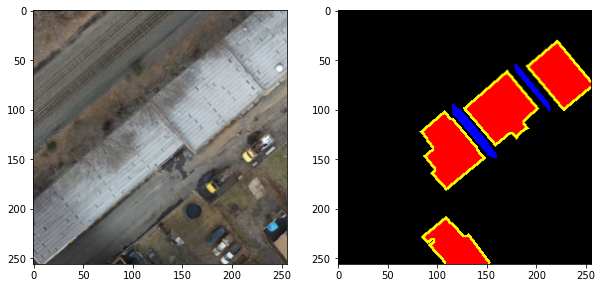

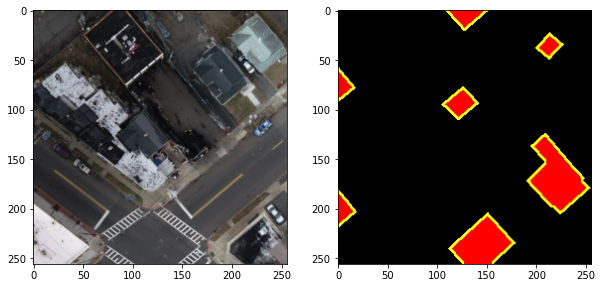

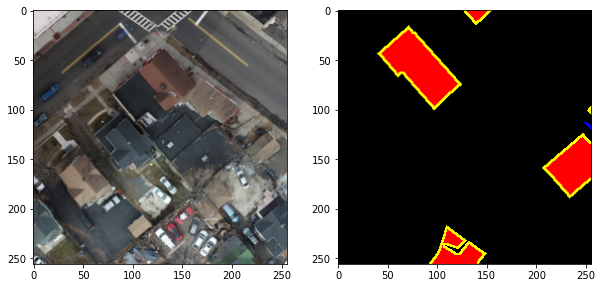

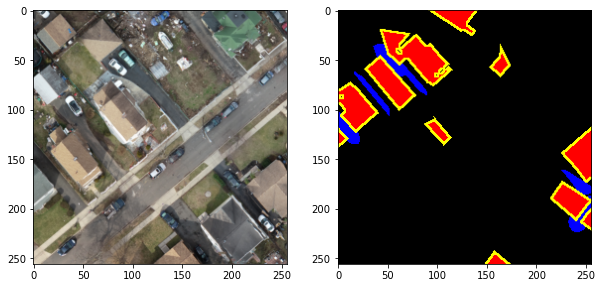

In [52]:
start_idx, end_idx = 400,405
for i,j in zip(sorted(img_path.iterdir())[start_idx:end_idx], sorted(mask_path.iterdir())[start_idx:end_idx]):
  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
  ax1.imshow(skimage.io.imread(i))
  ax2.imshow(skimage.io.imread(j))
  plt.show()